In [1]:
from astropy.time import Time
from lsst.summit.utils.efdUtils import getEfdData, makeEfdClient
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

from collections import defaultdict
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import re
import seaborn as sns

try:
    from lsst.ts.xml.tables.m1m3 import FATable
except ImportError:
    from lsst.ts.criopy.M1M3FATable import FATABLE as FATable

%matplotlib inline
%load_ext lab_black

## Bump Test Logs

### Querying Helper Function

In [3]:
async def query_bump_logs_in_chunks(
    start_date, end_date, client_name="", chunk_size_days=3
):
    """
    Queries bump logs in smaller chunks to avoid system overload.

    Parameters:
    start_date (str): Start date in ISO format (e.g., '2023-11-13T01:00').
    end_date (str): End date in ISO format (e.g., '2023-12-20T01:00').
    client_name (str): Name of the database client used for querying.
                       Options: 'summit_efd', 'usdf_efd', 'idf_efd'. Default is ''.
    chunk_size_days (int): Size of each chunk in days.

    Returns:
    DataFrame: Concatenated DataFrame containing all queried data.
    """

    # Conditionally create the client based on client_name
    if client_name == "summit_efd":
        client = makeEfdClient("summit_efd")
    elif client_name == "usdf_efd":
        client = makeEfdClient("usdf_efd")
    elif client_name == "idf_efd":
        client = makeEfdClient("idf_efd")
    else:
        client = makeEfdClient()  # Default client

    # Convert start and end dates to datetime objects
    start = datetime.fromisoformat(start_date)
    end = datetime.fromisoformat(end_date)

    # Initialize an empty DataFrame to store concatenated results
    all_data = pd.DataFrame()

    current_start = start
    while current_start < end:
        current_end = min(current_start + timedelta(days=chunk_size_days), end)
        try:
            # Query the data for the current chunk
            chunk_data = await client.select_time_series(
                topic_name="lsst.sal.MTM1M3.logevent_logMessage",
                fields=["message"],
                start=Time(current_start.isoformat(), format="isot", scale="utc"),
                end=Time(current_end.isoformat(), format="isot", scale="utc"),
            )
            # Concatenate the chunk data to the main DataFrame
            all_data = pd.concat([all_data, chunk_data], ignore_index=False)
        except Exception as e:
            print(
                f"Error querying data from {current_start.isoformat()} to {current_end.isoformat()}: {e}"
            )
            continue  # Optionally, continue to the next chunk

        # Move to the next chunk
        current_start = current_end

    return all_data


# Example usage:
# begin = "2023-11-13T01:00"
# end = "2023-12-21T01:00"
# bump_logs = await query_bump_logs_in_chunks(begin, end, client_name='')

### Making Client and Checkig schema

In [4]:
client = makeEfdClient()
schema = await client.get_schema("lsst.sal.MTM1M3.logevent_logMessage")
schema

,name,description,units,aunits,is_array
0,private_efdStamp,UTC time for EFD timestamp. An integer (the nu...,second,s,False
1,private_kafkaStamp,TAI time at which the Kafka message was created.,second,s,False
2,private_revCode,Revision hashcode,unitless,,False
3,private_sndStamp,Time of instance publication,second,s,False
4,private_rcvStamp,Time of instance reception,second,s,False
5,private_seqNum,Sequence number,unitless,,False
6,private_identity,Identity of publisher,unitless,,False
7,private_origin,PID of publisher,unitless,,False
8,name,Log name.,unitless,,False
9,level,"Message level, a Python logging level: error=4...",unitless,,False


### Getting log messages

#### Querying EFD

In [5]:
# Note that date between 09-12 and 12-12 are returning error when querying.
# For this reason, I'm avoid to query those dates.
begin = "2023-11-01T01:00"
end = "2023-12-09T01:00"
bump_logs_1 = await query_bump_logs_in_chunks(
    begin, end, client_name="", chunk_size_days=3
)

begin = "2023-12-12T01:00"
end = "2024-01-15T23:59"
bump_logs_2 = await query_bump_logs_in_chunks(
    begin, end, client_name="", chunk_size_days=3
)

bump_logs = pd.concat([bump_logs_1, bump_logs_2], ignore_index=False)
bump_logs

,message
2023-11-01 01:00:30.474714+00:00,ILCResponseParser: Invalid CRC (or extra byte)...
2023-11-01 01:00:30.475548+00:00,ILCResponseParser: Hardpoint 6 (ID 6) actuator...
2023-11-01 01:01:30.488362+00:00,ILCResponseParser: Invalid CRC (or extra byte)...
2023-11-01 01:01:30.488641+00:00,ILCResponseParser: Hardpoint 6 (ID 6) actuator...
2023-11-01 01:02:30.488759+00:00,ILCResponseParser: Invalid CRC (or extra byte)...
...,...
2024-01-15 13:07:27.091913+00:00,ILCResponseParser: Hardpoint 6 (ID 6) actuator...
2024-01-15 13:08:27.577041+00:00,ILCResponseParser: Invalid CRC (or extra byte)...
2024-01-15 13:08:27.577661+00:00,ILCResponseParser: Hardpoint 6 (ID 6) actuator...
2024-01-15 13:09:27.610429+00:00,ILCResponseParser: Invalid CRC (or extra byte)...


In [6]:
# Place holder code to print the full error mesage
# for m in bump_logs[bump_logs.message.str.contains("Failed FA")].message:
#    print(m)

#### Processing Bump Log

In [34]:
# Function to process the bump log
def process_bump_logs(bump_logs, expected_force_range=222, tolerance=5):
    """
    Processes bump log messages to extract relevant information and calculate deviations.

    Parameters:
    bump_logs (DataFrame): DataFrame containing bump log messages.

    Returns:
    DataFrame: A processed DataFrame with extracted and calculated data.
    """
    # Filter the bump logs
    filtered_bump_log = bump_logs[bump_logs.message.str.contains("Failed FA")].message
    df_filtered_bump_log = pd.DataFrame(filtered_bump_log)

    # Process the bump log messages
    # Extract FA ID, Orientation, Index, and Error Message
    df_filtered_bump_log["ID"] = df_filtered_bump_log["message"].str.extract(
        r"FA ID (\d+)"
    )
    orientation_index = df_filtered_bump_log["message"].str.extract(r"\(([XYZ])(\d+)\)")
    df_filtered_bump_log["Orientation"] = orientation_index[0]
    df_filtered_bump_log["Index"] = orientation_index[1]
    df_filtered_bump_log["Error Message"] = df_filtered_bump_log["message"].str.extract(
        r"- (.+)$"
    )

    # Create a new DataFrame with the required columns
    new_df = df_filtered_bump_log.reset_index().rename(columns={"index": "Time"})[
        ["Time", "ID", "Orientation", "Index", "Error Message"]
    ]

    # Calculate deviations and classify error types
    # Extract Measured Force
    new_df["MeasuredForce"] = (
        new_df["Error Message"].str.extract(r"\(([\-\d.]+)\)").astype(float)
    )

    # Filter out entries with zero force applied
    new_df = new_df[new_df["MeasuredForce"] != 0]

    # Classify applied force direction and calculate deviation
    new_df["AppliedForceDirection"] = new_df["Error Message"].apply(
        lambda x: "Positive" if "measured force plus" in x else "Negative"
    )

    # Initialize deviation columns
    new_df["Deviation"] = 0

    # Upper and lower limits (
    upper_limit = expected_force_range  # + tolerance
    lower_limit = -expected_force_range  # - tolerance

    # Ensure Deviation column is float
    new_df["Deviation"] = new_df["Deviation"].astype(float)

    # Calculate deviation based on the direction of the applied force direction
    for index, row in new_df.iterrows():
        if row["AppliedForceDirection"] == "Positive":
            new_df.at[index, "Deviation"] = float(row["MeasuredForce"]) - upper_limit
        elif row["AppliedForceDirection"] == "Negative":
            new_df.at[index, "Deviation"] = float(row["MeasuredForce"]) - lower_limit

    return new_df


# Usage
processed_bump_logs = process_bump_logs(bump_logs)
processed_bump_logs.head()

,Time,ID,Orientation,Index,Error Message,MeasuredForce,AppliedForceDirection,Deviation
0,2023-11-08 07:53:36.997764+00:00,101,Z,0,measured force plus (15.167) is too far 222±5,15.167,Positive,-206.833
1,2023-11-15 15:57:34.986008+00:00,108,Z,7,measured force plus (227.724) is too far 222±5,227.724,Positive,5.724
2,2023-11-15 16:18:56.685593+00:00,227,Z,61,measured force plus (213.108) is too far 222±5,213.108,Positive,-8.892
3,2023-11-15 17:02:04.654482+00:00,227,Z,61,measured force plus (215.394) is too far 222±5,215.394,Positive,-6.606
4,2023-11-15 17:02:38.174948+00:00,227,Z,61,measured force plus (215.020) is too far 222±5,215.020,Positive,-6.980


### Plotting Functions

In [35]:
def plot_failure_histogram(df, ax):
    """
    Plots a histogram of failures by FA ID and Orientation with colors based on a predefined dictionary.
    The legend is automatically generated.

    Parameters:
    df (DataFrame): DataFrame containing failure data.
    ax (matplotlib.axes.Axes): Axes object to plot the histogram.
    """

    # Define color scheme for orientations
    orientation_colors = {"X": "blue", "Y": "red", "Z": "green"}

    # Convert 'Time' column to datetime and extract the date part
    df["Time"] = pd.to_datetime(df["Time"]).dt.date

    # Aggregate the total number of failures per FA ID and Orientation
    total_failures_per_faid = df.groupby("ID").size()
    grouped_data = df.groupby(["ID", "Orientation"]).size().unstack(fill_value=0)
    sorted_grouped_data = grouped_data.reindex(
        total_failures_per_faid.sort_values(ascending=False).index
    )

    # Colors for present orientations
    bar_colors = {
        ori: orientation_colors[ori]
        for ori in grouped_data.columns
        if ori in orientation_colors
    }

    # Plotting with specified colors
    sorted_grouped_data.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        alpha=0.8,
        color=[bar_colors.get(col) for col in grouped_data.columns],
    )

    # Set title and labels
    ax.set_title("Failures by FA ID and Orientation")
    ax.set_xlabel("FA ID")
    ax.set_ylabel("Number of Failures")

    # Generate the legend automatically
    ax.legend(title="Orientation")

    return ax


# Getting primary {id: index} dictionary
m1m3_actuator_id_index_table: dict[int, int] = dict(
    [(fa.actuator_id, fa.index) for fa in FATable]
)


def get_m1m3_actuator_ids() -> list[int]:
    """Get a list of the M1M3 actuator ids.

    Returns
    -------
    `list`[ `int` ]
        List of M1M3 actuator ids.
    """
    return list(m1m3_actuator_id_index_table.keys())


def get_xy_position(actuator_list=FATable):
    # Collect all x and y positions using list comprehensions
    xpos = [actuator.x_position for actuator in actuator_list]
    ypos = [actuator.y_position for actuator in actuator_list]

    return xpos, ypos


def ActuatorsLayout(ax, df, actuator_list=FATable):
    """
    Function to plot the layout of actuators based on a DataFrame and highlight the failed ones with different colors based on orientation.
    Labels multiple orientations as 'XZ' or 'YZ'. Includes both individual and combined orientations in the legend.

    Parameters:
    ax (matplotlib.axes.Axes): Axes object to plot the actuators.
    df (DataFrame): DataFrame containing failure data including 'ID' and 'Orientation'.
    actuator_list (list): List of actuator objects, default is FATable.
    """

    orientation_colors = {"X": "blue", "Y": "red", "Z": "green"}
    combined_orientations_colors = {"XZ": "orange", "YZ": "black"}

    ax.set_xlabel("X position (m)")
    ax.set_ylabel("Y position (m)")
    ax.set_title("Failures Distribution", fontsize=12)

    ids = get_m1m3_actuator_ids()
    xpos, ypos = get_xy_position(actuator_list)

    # Create a defaultdict to store orientations for each failed actuator
    actuator_orientations = defaultdict(set)
    for actuator_id, orientation in zip(df["ID"], df["Orientation"]):
        actuator_orientations[int(actuator_id)].add(orientation)

    # Determine all unique individual and combined orientations
    unique_orientations = set()
    combined_orientations = set()
    for orientations in actuator_orientations.values():
        if len(orientations) == 1:
            unique_orientations.update(orientations)
        else:
            combined_label = "".join(sorted(orientations))
            combined_orientations.add(combined_label)

    # Plot all actuators
    ax.plot(xpos, ypos, "o", ms=14, color="blue", alpha=0.05, mec="red")

    # Annotate actuator IDs
    for l, x, y in zip(ids, xpos, ypos):
        ax.annotate(
            l,
            (x, y),
            textcoords="offset points",
            xytext=(-5.5, -2),
            color="blue",
            size="xx-small",
        )

    # Highlight failed actuators with different colors based on orientation
    for actuator_id, orientations in actuator_orientations.items():
        if actuator_id in m1m3_actuator_id_index_table:
            index = m1m3_actuator_id_index_table[actuator_id]
            if len(orientations) > 1:
                combined_orientation = "".join(sorted(orientations))
                color = combined_orientations_colors[combined_orientation]
            else:
                orientation = orientations.pop()
                color = orientation_colors[orientation]
            ax.scatter(
                xpos[index],
                ypos[index],
                marker="o",
                facecolors="none",
                edgecolors=color,
                s=250,
                alpha=0.5,
                linewidths=2,
            )

    # Additional plotting (e.g., for some reference points)
    Rhp = 3.1  # Radius in meters
    for i in range(6):
        theta = 2.0 * np.pi / 6.0 * float(i)
        ax.scatter(
            Rhp * np.cos(theta),
            Rhp * np.sin(theta),
            marker="*",
            color="green",
            s=30,
            alpha=0.3,
        )

    # Add a legend for orientations, including both individual and combined orientations
    for orientation in unique_orientations:
        ax.scatter(
            [],
            [],
            marker="o",
            linestyle="None",
            s=10,
            facecolor="none",
            edgecolor=orientation_colors[orientation],
            alpha=0.9,
            label=f"Orientation {orientation}",
        )
    for combined_orientation in combined_orientations:
        ax.scatter(
            [],
            [],
            marker="o",
            linestyle="None",
            s=10,
            facecolor="none",
            edgecolor=combined_orientations_colors[combined_orientation],
            alpha=0.5,
            label=f"Orientation {combined_orientation}",
        )
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

    return

### Histogram + Spatial distribution

#### Obtaining the processed bump log with force and all inforamtin needed

In [36]:
processed_bump_log = process_bump_logs(bump_logs)
df = processed_bump_log.copy()

df.tail()

,Time,ID,Orientation,Index,Error Message,MeasuredForce,AppliedForceDirection,Deviation
266,2024-01-11 03:32:27.256765+00:00,410,Z,124,measured force negative (-232.814) is too far ...,-232.814,Negative,-10.814
269,2024-01-12 05:33:09.995534+00:00,218,Z,53,measured force plus (228.118) is too far 222±5,228.118,Positive,6.118
270,2024-01-12 05:42:09.984656+00:00,238,Y,49,measured force plus (227.884) is too far 222±5,227.884,Positive,5.884
271,2024-01-12 06:03:23.393150+00:00,410,Z,124,measured force plus (227.344) is too far 222±5,227.344,Positive,5.344
272,2024-01-12 23:51:47.656476+00:00,104,Z,3,measured force plus (216.005) is too far 222±5,216.005,Positive,-5.995


In [20]:
# df.Orientation.unique()

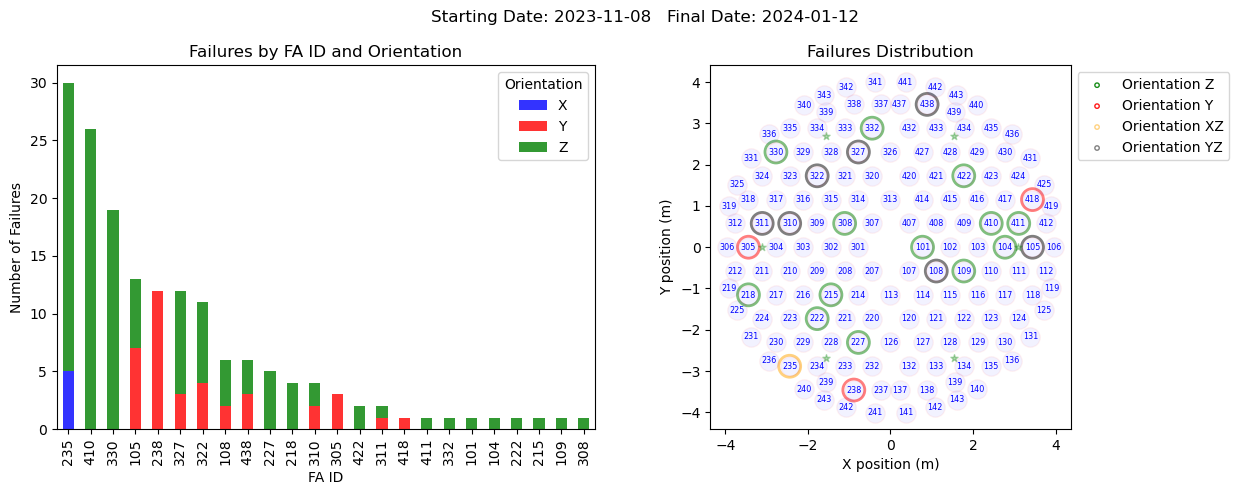

In [37]:
# Create the figure and axes
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(13, 5))

# Histogram aspect should be automatic
ax0.set_aspect("auto", adjustable="box")

# Layout figre aspect needs to be rectangular
ax1.set_aspect("equal", adjustable="box")

# Call the function to plot the actuators and flag the failed ones
plot_failure_histogram(df, ax0)

# Call the function to plot the actuators and flag the failed ones
ActuatorsLayout(ax1, df, actuator_list=FATable)

# Find the first and last date in the entire dataset
first_date = df["Time"].min()
last_date = df["Time"].max()

plt.suptitle(
    f"Starting Date: {first_date.strftime('%Y-%m-%d')}   Final Date: {last_date.strftime('%Y-%m-%d')}"
)

plt.tight_layout()

plt.savefig("histogram+distribution_of_failures.png", dpi=300)

### Plotting the errors:

#### Helper fuction

#### Running the plot

In [51]:
def plot_aligned_deviations_and_measurements_with_dates_color_bar(df):
    """
    Creates a bar plot for deviations sorted by the number of failures and overlays a scatter plot of measured forces.
    Adjusts the width of the bars for better alignment with the scatter points. Uses different markers for positive
    and negative deviations and adds a colorbar to indicate the date of measurements.

    Parameters:
    df (DataFrame): DataFrame containing failure data.
    """

    # Define color scheme for positive and negative deviations
    color_scheme = {"Positive": "blue", "Negative": "red"}

    # Calculate the number of failures per ID and sort
    failure_counts = df.groupby("ID").size().sort_values(ascending=False)
    sorted_ids = failure_counts.index.tolist()

    # Sort the DataFrame based on the sorted IDs
    df["ID"] = pd.Categorical(df["ID"], categories=sorted_ids, ordered=True)
    df_sorted = df.sort_values("ID")

    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 5))

    # Bar Plot for Deviations with adjusted bar width
    sns.barplot(
        x="ID",
        y="Deviation",
        hue="AppliedForceDirection",
        data=df_sorted,
        ax=ax,
        palette=color_scheme,
        dodge=False,
        edgecolor="none",
        linewidth=0,
        width=0.3,
    )

    # Function to map ID to position for scatter plot
    def map_id_to_position(df):
        return df["ID"].cat.codes

    # Convert 'Time' to numerical format for color mapping
    df_sorted["Time_Num"] = mdates.date2num(df_sorted["Time"])

    # Scatter Plot for Measured Forces, separated by applied force direction with different markers
    # Positive direction
    sc1 = ax.scatter(
        map_id_to_position(df_sorted[df_sorted["AppliedForceDirection"] == "Positive"]),
        df_sorted[df_sorted["AppliedForceDirection"] == "Positive"]["MeasuredForce"],
        c=df_sorted[df_sorted["AppliedForceDirection"] == "Positive"]["Time_Num"],
        marker="o",
        label="Positive Side",
        alpha=0.6,
        cmap="viridis",
    )

    # Negative direction
    sc2 = ax.scatter(
        map_id_to_position(df_sorted[df_sorted["AppliedForceDirection"] == "Negative"]),
        df_sorted[df_sorted["AppliedForceDirection"] == "Negative"]["MeasuredForce"],
        c=df_sorted[df_sorted["AppliedForceDirection"] == "Negative"]["Time_Num"],
        marker="s",
        label="Negative Side",
        alpha=0.6,
        cmap="viridis",
    )

    # Adding a colorbar for dates
    cbar = plt.colorbar(sc1, ax=ax, pad=0.01)
    cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    cbar.set_label("Measurement Date")

    # Expected force range and tolerance
    expected_force_range = 222
    tolerance = 5

    # Adding horizontal lines and shaded areas for tolerances
    ax.axhline(expected_force_range, color="blue", linestyle="-")
    ax.axhline(-expected_force_range, color="red", linestyle="-")
    ax.fill_between(
        range(len(sorted_ids)),
        expected_force_range - tolerance,
        expected_force_range + tolerance,
        color="blue",
        alpha=0.3,
    )
    ax.fill_between(
        range(len(sorted_ids)),
        -expected_force_range - tolerance,
        -expected_force_range + tolerance,
        color="red",
        alpha=0.3,
    )

    # Adding titles and labels
    ax.set_title("Deviations and Measured Forces by FA ID")
    ax.set_xlabel("FA ID")
    ax.set_ylabel("Deviation / Measured Force")

    # Create custom legend entries for marker types
    positive_marker = mlines.Line2D(
        [],
        [],
        color="black",
        marker="o",
        linestyle="None",
        markersize=6,
        label="Positive Side",
    )
    negative_marker = mlines.Line2D(
        [],
        [],
        color="black",
        marker="s",
        linestyle="None",
        markersize=6,
        label="Negative Side",
    )

    # Adjusting the legend to include only custom markers
    ax.legend(handles=[positive_marker, negative_marker], loc="upper right")

    plt.tight_layout()
    plt.savefig("deviation_measured_forces_with_age_of_error.png", dpi=300)
    plt.show()

/tmp/ipykernel_723/1111826808.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  failure_counts = df.groupby("ID").size().sort_values(ascending=False)


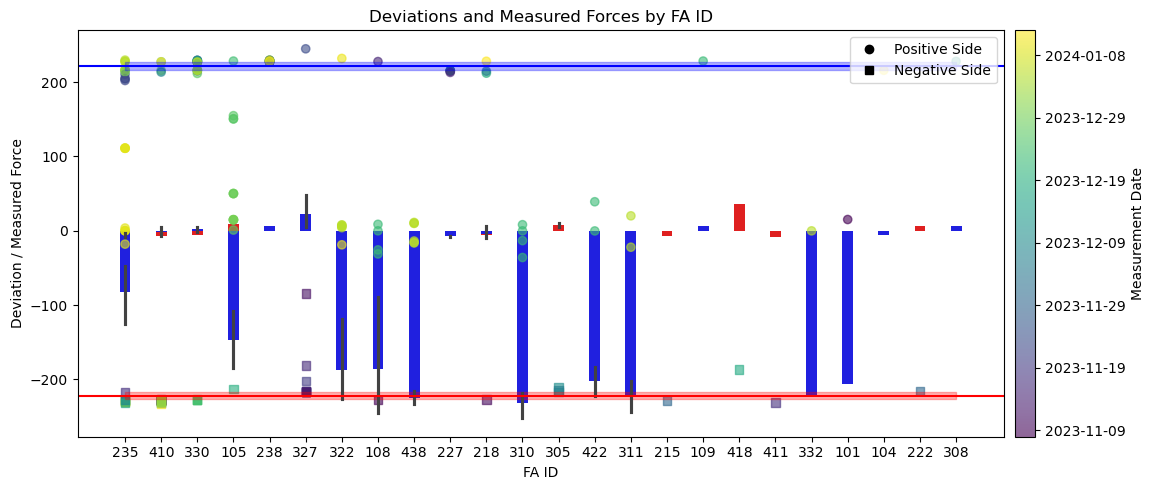

In [52]:
# Applying the function to the DataFrame
plot_aligned_deviations_and_measurements_with_dates_color_bar(df)

In [65]:
def plot_absolute_measured_forces_with_age(df):
    """
    Modified function to create a scatter plot of absolute measured forces, with x-axis showing actuator IDs
    and a colorbar to indicate the date of measurements. Uses different markers for positive and negative errors.

    Parameters:
    df (DataFrame): DataFrame containing failure data.
    """

    # Expected force range and tolerance
    expected_force_range = 222
    tolerance = 5

    # Convert MeasuredForce to absolute values
    df["AbsMeasuredForce"] = df["MeasuredForce"].abs()

    # Calculate the mean and standard deviation for y-axis limits
    mean_force = df["AbsMeasuredForce"].mean()
    std_dev_force = df["AbsMeasuredForce"].std()
    y_min = max(0, mean_force - 7 * std_dev_force)  # Ensuring y_min is not negative
    y_max = mean_force + 1 * std_dev_force

    # Calculate the number of failures per ID and sort
    failure_counts = df.groupby("ID", observed=True).size().sort_values(ascending=False)
    sorted_ids = failure_counts.index.tolist()

    # Sort the DataFrame based on the sorted IDs
    df["ID"] = pd.Categorical(df["ID"], categories=sorted_ids, ordered=True)
    df_sorted = df.sort_values("ID")

    # Create a plot
    fig, ax = plt.subplots(figsize=(12, 5))

    # Function to map ID to position for scatter plot
    def map_id_to_position(dev_df):
        return dev_df["ID"].cat.codes

    # Convert 'Time' to numerical format for color mapping
    df_sorted["Time_Num"] = mdates.date2num(df_sorted["Time"])

    # Scatter Plot for Absolute Measured Forces, separated by AppliedForceDirection with different markers
    # Positive Direction
    sc1 = ax.scatter(
        map_id_to_position(df_sorted[df_sorted["AppliedForceDirection"] == "Positive"]),
        df_sorted[df_sorted["AppliedForceDirection"] == "Positive"]["AbsMeasuredForce"],
        c=df_sorted[df_sorted["AppliedForceDirection"] == "Positive"]["Time_Num"],
        marker="o",
        label="Positive Side",
        alpha=0.9,
        cmap="viridis",
    )

    # Negative Direction
    sc2 = ax.scatter(
        map_id_to_position(df_sorted[df_sorted["AppliedForceDirection"] == "Negative"]),
        df_sorted[df_sorted["AppliedForceDirection"] == "Negative"]["AbsMeasuredForce"],
        c=df_sorted[df_sorted["AppliedForceDirection"] == "Negative"]["Time_Num"],
        marker="s",
        label="Negative Side",
        alpha=0.9,
        cmap="viridis",
    )

    # Adding horizontal lines and shaded areas for tolerances
    ax.axhline(
        expected_force_range,
        color="gray",
        linestyle="--",
        linewidth=0.9,
        label="+/- 222 N",
    )
    ax.fill_between(
        range(len(sorted_ids)),
        expected_force_range - tolerance,
        expected_force_range + tolerance,
        color="gray",
        alpha=0.3,
    )

    # Set x-ticks to be the categorical IDs and label them with the sorted IDs
    ax.set_xticks(range(len(sorted_ids)))
    ax.set_xticklabels(sorted_ids, rotation=45)

    # Adding a colorbar for dates
    cbar = plt.colorbar(sc1, ax=ax, pad=0.01)
    cbar.ax.yaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    cbar.set_label("Measurement Date")

    # Set y-axis limits
    # ax.set_ylim(y_min, y_max)

    # Adding titles and labels
    ax.set_title("Absolute Measured Forces by FA ID")
    ax.set_xlabel("FA ID")
    ax.set_ylabel("Absolute Measured Force")

    # Adjusting the legend to include marker types only
    ax.legend(loc="best")

    plt.tight_layout()
    plt.savefig("absolute_measured_forces_with_age_of_error.png", dpi=300)
    plt.show()

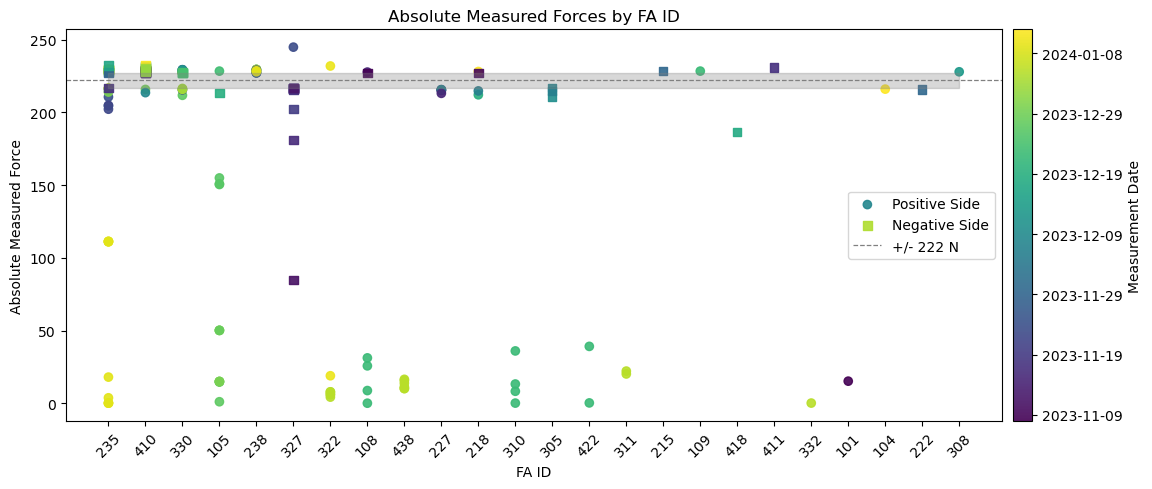

In [67]:
# Running the plot
plot_absolute_measured_forces_with_age(df)

In [68]:
def plot_average_deviation_by_id(df):
    """
    Creates a bar plot of the average deviation for each actuator ID, separated by error type.

    Parameters:
    df (DataFrame): DataFrame containing data with deviations and error types.
    """
    # Calculating the average deviation for each Actuator ID, separated by force direction
    avg_deviation_by_id_and_error = (
        df.groupby(["ID", "AppliedForceDirection"], observed=True)["Deviation"]
        .mean()
        .unstack()
    )

    # Plotting the average deviation for each Actuator ID, separated by error type
    avg_deviation_by_id_and_error.plot(kind="bar", figsize=(15, 6), alpha=0.7)
    plt.title("Average Deviation by Actuator ID and Error Type")
    plt.xlabel("Actuator ID")
    plt.ylabel("Average Deviation")
    plt.legend(title="Applied Force Direction", loc="lower right")
    plt.grid(axis="y")
    plt.show()

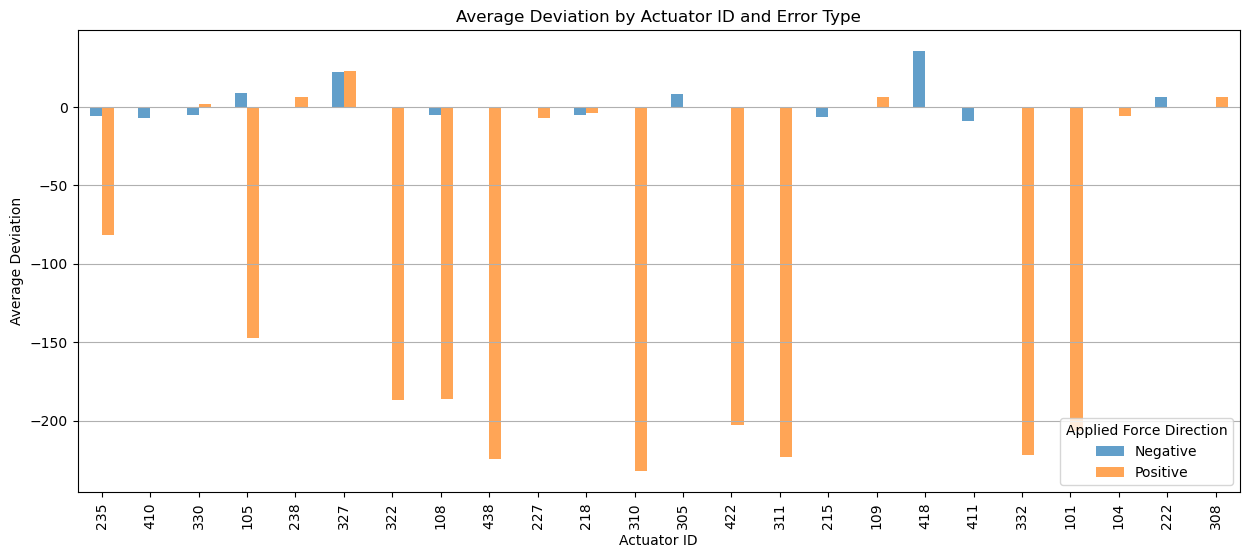

In [69]:
# Example usage of the function
plot_average_deviation_by_id(df)

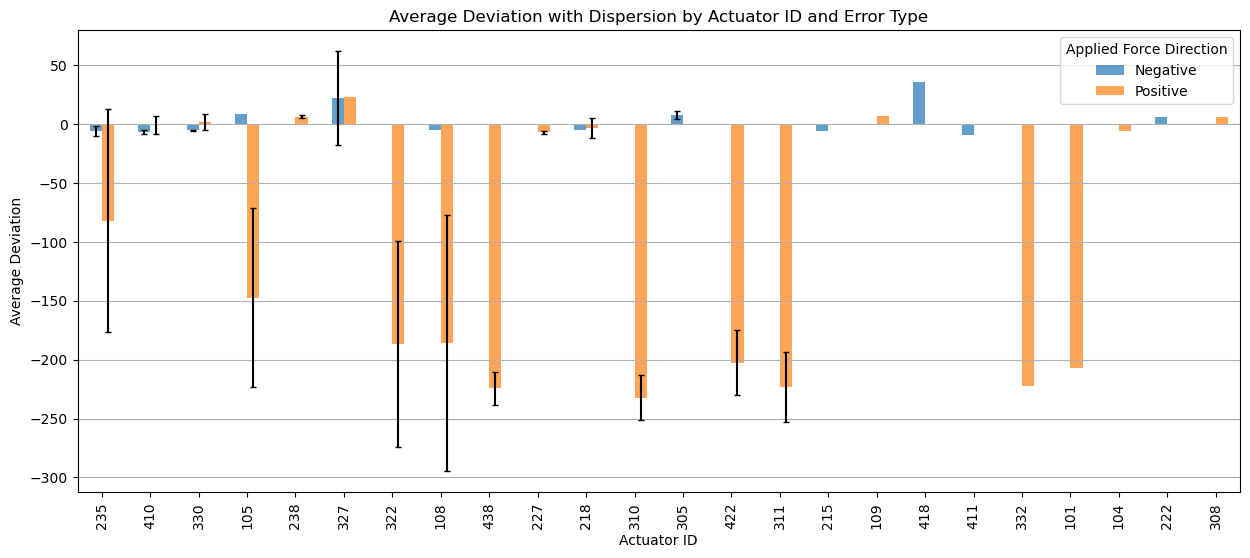

In [74]:
def plot_avg_deviation_with_error_bars(df):
    """
    Creates a bar plot of the average deviation for each actuator ID, separated by error type,
    with error bars representing the standard deviation.

    Parameters:
    df (DataFrame): DataFrame containing data with deviations and error types.
    """
    # Calculating the average deviation and standard deviation for each Actuator ID, separated by error type
    avg_deviation = (
        df.groupby(["ID", "AppliedForceDirection"], observed=True)["Deviation"]
        .mean()
        .unstack()
    )
    std_deviation = (
        df.groupby(["ID", "AppliedForceDirection"], observed=True)["Deviation"]
        .std()
        .unstack()
    )

    # Creating the bar plot with error bars
    ax = avg_deviation.plot(
        kind="bar", yerr=std_deviation, figsize=(15, 6), alpha=0.7, capsize=2
    )

    # Setting the title and labels
    plt.title("Average Deviation with Dispersion by Actuator ID and Error Type")
    plt.xlabel("Actuator ID")
    plt.ylabel("Average Deviation")
    plt.legend(title="Applied Force Direction")
    plt.grid(axis="y")
    plt.show()


# Example usage of the function
plot_avg_deviation_with_error_bars(df)

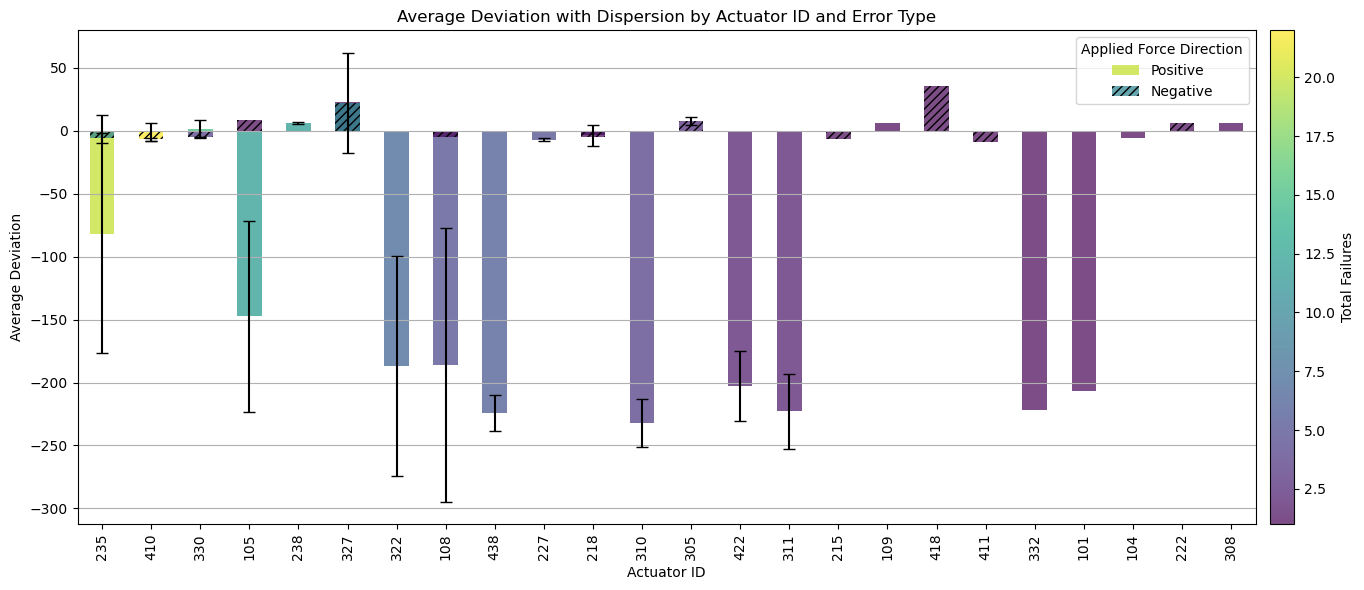

In [75]:
import matplotlib.colors as mcolors


def plot_avg_deviation_with_color_bar(df):
    # Calculating the average deviation and standard deviation for each Actuator ID, separated by error type
    avg_deviation = (
        df.groupby(["ID", "AppliedForceDirection"], observed=True)["Deviation"]
        .mean()
        .unstack()
    )
    std_deviation = (
        df.groupby(["ID", "AppliedForceDirection"], observed=True)["Deviation"]
        .std()
        .unstack()
    )
    count_deviation = (
        df.groupby(["ID", "AppliedForceDirection"], observed=True)["Deviation"]
        .size()
        .unstack()
    )

    # Normalize the count deviation for color mapping
    norm = mcolors.Normalize(vmin=1, vmax=count_deviation.max().max())
    cmap = plt.cm.viridis

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(15, 6))

    # Define hatch patterns
    hatch_patterns = {
        "Positive": "",
        "Negative": "////",
    }  # Example: no hatch for positive, slashes for negative

    # Iterate over the error types and plot each set of bars with the appropriate hatch pattern
    for error_type, hatch in hatch_patterns.items():
        bar_colors = cmap(norm(count_deviation[error_type].values))
        avg_deviation[error_type].plot(
            kind="bar",
            yerr=std_deviation[error_type],
            ax=ax,
            color=bar_colors,
            capsize=4,
            hatch=hatch,  # Apply hatch pattern
            label=error_type,
            alpha=0.7,
        )

    # Create color bar with a pad of 0.01
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, pad=0.01, alpha=0.7)
    cbar.set_label("Total Failures")

    # Setting the title and labels
    plt.title("Average Deviation with Dispersion by Actuator ID and Error Type")

    plt.xlabel("Actuator ID")
    plt.ylabel("Average Deviation")
    plt.legend(title="Applied Force Direction")
    plt.grid(axis="y")

    plt.tight_layout()
    plt.savefig("average_deviation_with_dispersion_and_colorbar.png", dpi=300)
    plt.show()


# Example usage of the function
plot_avg_deviation_with_color_bar(df)

In [76]:
def plot_absolute_measured_force_over_time(df, top_n=15):
    expected_force = 222
    tolerance = 5

    # Convert 'Time' to datetime if not already
    df["Time"] = pd.to_datetime(df["Time"])

    # Calculate days since the first date for the entire dataset
    first_date = df["Time"].min()
    last_date = df["Time"].max()
    total_days = (last_date - first_date).days
    df["DaysSinceFirst"] = (df["Time"] - first_date).dt.days

    # Use absolute values of measured force
    df["AbsMeasuredForce"] = df["MeasuredForce"].abs()

    # Calculate the average and standard deviation for setting y-axis limits
    std_dev_force = df["AbsMeasuredForce"].std()
    y_min = max(0, expected_force - 7 * std_dev_force)  # Ensuring y_min is not negative
    y_max = expected_force + 7 * std_dev_force

    # Find the top N actuators with the highest frequency of failures
    top_actuators = df["ID"].value_counts().head(top_n).index

    # Number of columns for subplots (5 rows)
    n_cols = (top_n + 4) // 5

    # Create a figure with subplots
    fig, axs = plt.subplots(
        5, n_cols, figsize=(5 * n_cols, 10), sharex=True, sharey=False
    )

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    # Create a full range for the fill_between based on the entire dataset
    full_range = range(total_days + 1)  # +1 to include the last day

    # Plot each actuator's absolute measured forces over time in a separate subplot
    for i, actuator_id in enumerate(top_actuators):
        ax = axs[i]
        actuator_data = df[df["ID"] == actuator_id]

        # Scatter plot for absolute measured forces differentiated by error type
        ax.scatter(
            actuator_data[actuator_data["AppliedForceDirection"] == "Positive"][
                "DaysSinceFirst"
            ],
            actuator_data[actuator_data["AppliedForceDirection"] == "Positive"][
                "AbsMeasuredForce"
            ],
            marker="o",
            color="blue",
            label="Positive" if i == 0 else "",
            alpha=0.6,
        )
        ax.scatter(
            actuator_data[actuator_data["AppliedForceDirection"] == "Negative"][
                "DaysSinceFirst"
            ],
            actuator_data[actuator_data["AppliedForceDirection"] == "Negative"][
                "AbsMeasuredForce"
            ],
            marker="s",
            color="red",
            label="Negative" if i == 0 else "",
            alpha=0.6,
        )

        # Shaded area for tolerance range
        ax.axhline(
            expected_force - tolerance, color="green", linestyle="--", linewidth=0.3
        )
        ax.axhline(
            expected_force + tolerance, color="green", linestyle="--", linewidth=0.3
        )
        ax.fill_between(
            full_range,
            expected_force - tolerance,
            expected_force + tolerance,
            color="green",
            alpha=0.3,
        )

        # Actuator ID as title inside the plot area
        ax.text(
            0.05,
            0.95,
            f"FA {actuator_id}",
            transform=ax.transAxes,
            verticalalignment="top",
        )

        # Set y-axis limits based on the calculated average and standard deviation
        # ax.set_ylim(-50, 300)

        # Set labels only for the outermost subplots
        if i // n_cols == 4:  # Last row
            ax.set_xlabel(f"Days Since {first_date.strftime('%Y-%m-%d')}")
        if i % n_cols == 0:  # First column
            ax.set_ylabel("Abs. Measured Force")

        # Legend only for the first subplot
        if i == 0:
            ax.legend(loc="lower right")

    plt.suptitle("Absolute Measured Force for Failed Actuators", fontsize=14)

    # Adjust layout to remove spaces between subpanels
    plt.tight_layout(w_pad=0)
    plt.savefig("absolute_measured_force_over_time.png", dpi=300)
    plt.show()  # ax.set_ylim(y_min, y_max)

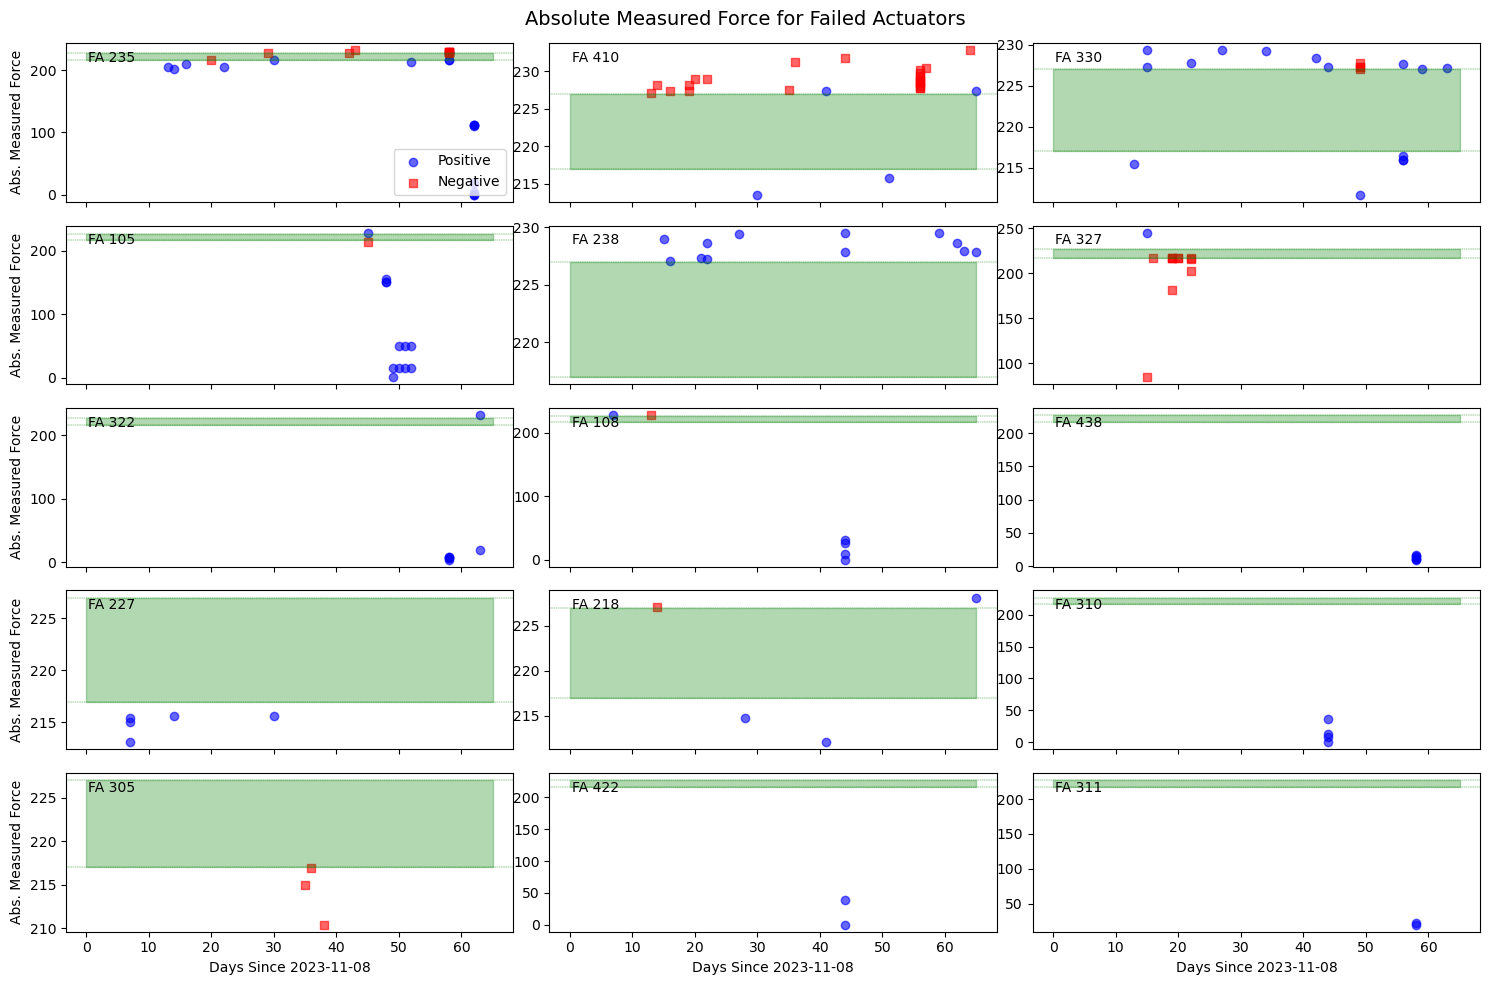

In [77]:
# Example usage:
plot_absolute_measured_force_over_time(df, top_n=15)